In [130]:
import os
import cv2
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [129]:
# Ruta del dataset en Kaggle
#dataset_path = "/Users/davis/VSCode/Information Retrieval/IREI-CBIR_faces/input/artfaces"
dataset_path = "/Users/davis/VSCode/Information Retrieval/IREI-CBIR_faces/input/portrain_painting"

In [159]:
# Function to load images from a folder and return image names
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
                images.append((img, filename))
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    print(f"Total images loaded: {len(images)}")
    return images


In [160]:
# Load Haar cascades for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Function to detect and analyze faces and eyes, and return positions
def detect_and_analyze_faces_eyes(image):
    # Convert to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract face region for eye detection
        face_roi = gray[y:y+h, x:x+w]
        
        # Detect eyes within the face region
        eyes = eyes_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
        
        # Check if exactly two eyes are detected
        if len(eyes) != 2:
            return None, None
        
        # Get eye centers and radiuses
        eye_centers = []
        for (ex, ey, ew, eh) in eyes:
            eye_center = (x + ex + ew//2, y + ey + eh//2)  # Tuple of (x, y)
            radius = int((ew + eh) * 0.25)  # Calculate radius for each eye
            eye_centers.append((eye_center, radius))  # Store as (center, radius) tuple
        
        # Sort eyes by x-coordinate to determine left/right
        eye_centers.sort(key=lambda point: point[0][0])  # Sort by x-coordinate of the center
        left_eye, right_eye = eye_centers
        
        # Get centers and radiuses for overlap check
        center1, radius1 = left_eye  # Unpack (center, radius) tuple
        center2, radius2 = right_eye  # Unpack (center, radius) tuple
        
        # Ensure center1 and center2 are tuples (x, y)
        if not isinstance(center1, tuple) or not isinstance(center2, tuple):
            return None, None  # Safety check if centers are not tuples
        
        # Unpack the (x, y) coordinates from center1 and center2
        x1, y1 = center1  # Unpack x, y from center1
        x2, y2 = center2  # Unpack x, y from center2

        # Calculate distance between eye centers
        distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        
        # Check if eyes overlap to filter out wrong detections
        if distance < (radius1 + radius2): 
            return None, None
        
        # Calculate face center
        face_center = (x + w//2, y + h//2)
        
        # Filter out pictures where one or more eyes are below the center of the face to filter out wrong detections
        if y1 > face_center[1] or y2 > face_center[1]:
            return None, None
        
        # Calculate head orientation (angle between eyes in degrees)
        dx = x2 - x1
        dy = y2 - y1
        orientation_angle = np.degrees(np.arctan2(dy, dx))  # Angle in degrees
        
        # Calculate head alignment vector as a triangle between the center of the eyes and the center of the face
        head_vector = np.array([
            x1, y1,                          # Left eye center
            x2, y2,                          # Right eye center
            face_center[0], face_center[1],  # Face center
            orientation_angle                # Head orientation
        ])
        
        # Draw visualization (optional, for debugging)
        annotated_image = image.copy()
        cv2.ellipse(annotated_image, face_center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 2)  # Pink ellipse for face
        cv2.circle(annotated_image, (int(x1), int(y1)), 10, (255, 0, 0), 2)  # Blue circle for left eye
        cv2.circle(annotated_image, (int(x2), int(y2)), 10, (255, 0, 0), 2)  # Blue circle for right eye
        
        # Draw head alignment vector
        cv2.line(annotated_image, center1, center2, (0, 255, 255), 2)  # Yellow line between the eyes
        cv2.line(annotated_image, center1, face_center, (0, 255, 0), 2)  # Green line from left eye to face center
        cv2.line(annotated_image, center2, face_center, (0, 255, 0), 2)  # Green line from right eye to face center
        return head_vector, annotated_image
    
    return None, None

# Load images from the dataset path
all_images= load_images_from_folder(dataset_path)

# Filter and collect images with one detected face and two eyes, along with their head alignment vectors
detected_images = []
img_names = []
head_vectors = []
for img, img_name in all_images:
    vector, annotated_img = detect_and_analyze_faces_eyes(img.copy())
    if vector is not None and annotated_img is not None:
        detected_images.append(annotated_img)
        head_vectors.append(vector)
        img_names.append(img_name)
    # Break to avoid processing all images (not needed for the demo)
    if len(detected_images) == 30:  
        break

# Count the number of images with detected faces and eyes
num_detected_images = len(detected_images)
print(f"Number of images with detected faces and eyes: {num_detected_images}")

Total images loaded: 5734
Number of images with detected faces and eyes: 30


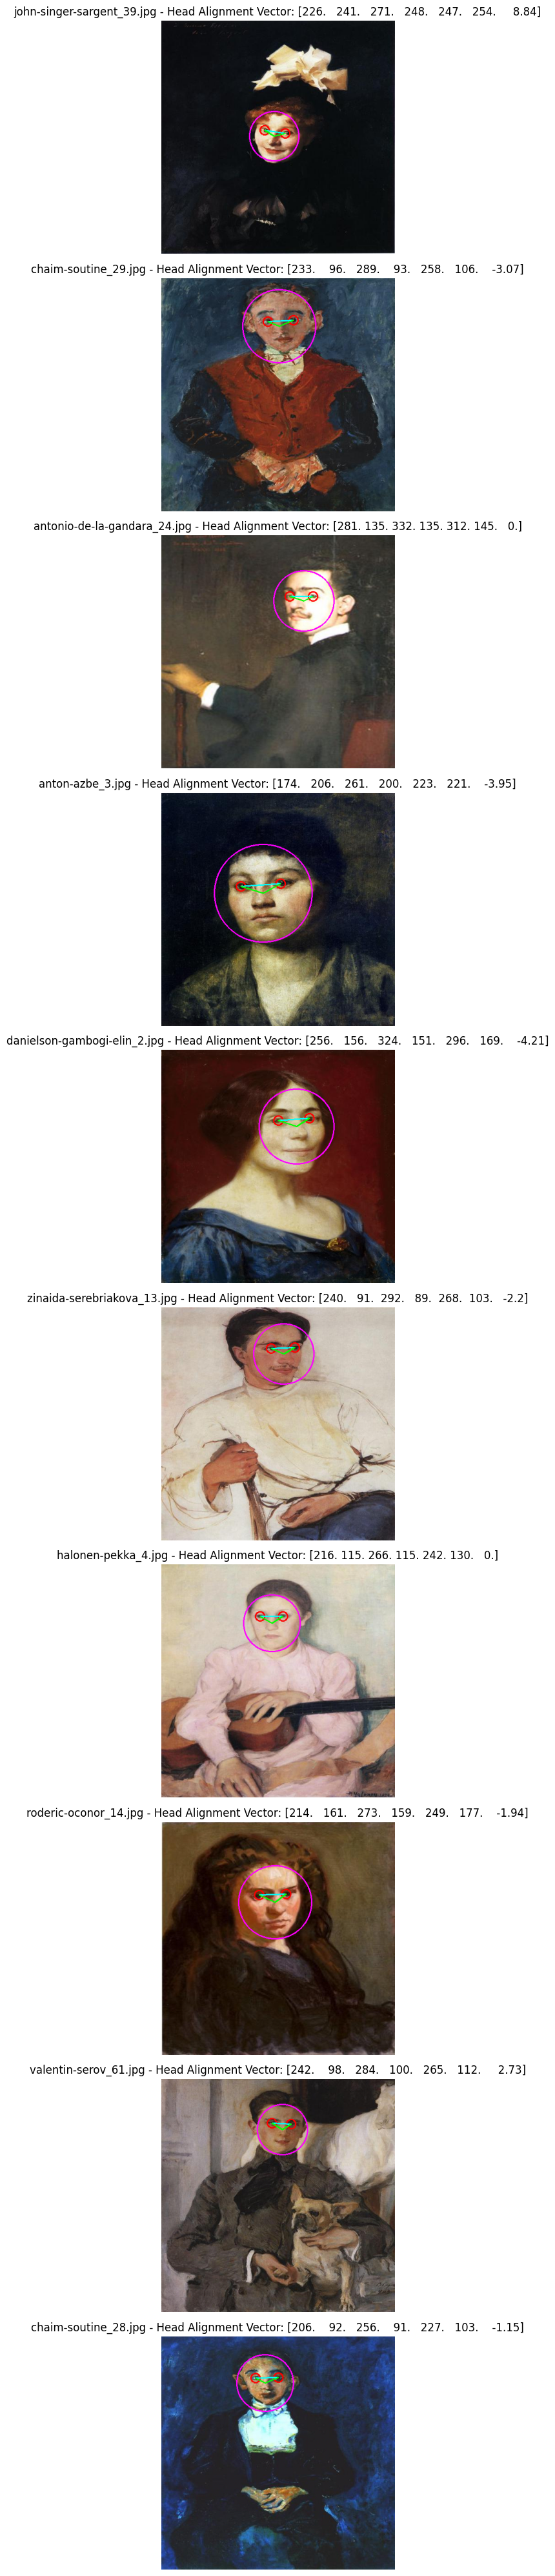


Head Alignment Vectors for All Detected Images:
Image 1: [229.   200.   299.   201.   267.   219.     0.82]
Image 2: [256.   156.   324.   151.   296.   169.    -4.21]
Image 3: [290.   125.   333.   131.   309.   140.     7.94]
Image 4: [226.   241.   271.   248.   247.   254.     8.84]
Image 5: [291.   225.   345.   228.   323.   246.     3.18]
Image 6: [271.    99.   310.   101.   289.   108.     2.94]
Image 7: [261.   194.   355.   198.   315.   212.     2.44]
Image 8: [187.  167.  259.  168.  225.  184.    0.8]
Image 9: [155.   182.   213.   183.   182.   197.     0.99]
Image 10: [241.   176.   320.   190.   272.   208.    10.05]
Image 11: [233.    96.   289.    93.   258.   106.    -3.07]
Image 12: [240.   91.  292.   89.  268.  103.   -2.2]
Image 13: [229.   168.   282.   171.   248.   179.     3.24]
Image 14: [147.   147.   171.   144.   160.   153.    -7.13]
Image 15: [216.   191.   277.   190.   248.   205.    -0.94]
Image 16: [242.   143.   299.   145.   268.   160.     2.01

In [161]:
# Display a few example images with their head alignment vectors
num_examples = min(10, len(detected_images))
example_indices = np.random.choice(len(detected_images), num_examples, replace=False)

plt.figure(figsize=(40, 40))
for i, idx in enumerate(example_indices):
    image = detected_images[idx]
    vector = head_vectors[idx]
    name = img_names[idx]
    plt.subplot(10, 1, i + 1)
    plt.imshow(image)
    plt.title(f"{name} - Head Alignment Vector: {vector.round(2)}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Optional: Print the head vectors for all detected images
print("\nHead Alignment Vectors for All Detected Images:")
for i, vector in enumerate(head_vectors):
    print(f"Image {i + 1}: {vector.round(2)}")